# Data Analysis - 2020 - Final project                                                                          
by **Bouzid Mohamed**

Link : https://www.kaggle.com/c/data-analysis-2020

In [ ]:
# import necessary libraries

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew,norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import linear_model 
sns.set()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
train = pd.read_csv("../input/data-analysis-2020/train.csv")
test = pd.read_csv("../input/data-analysis-2020/test.csv")
train.head()

,Id,date,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,next_day_ret
0,0,2018-01-02,725001,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,-161.101159
1,1,2018-01-02,340005,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,-91.056323
2,2,2018-01-02,730001,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,159.011983
3,3,2018-01-02,714001,ASSAD,9.00,0.00,0.00,9.00,0.00,0.00,0,0,NaN,-98.000768
4,4,2018-01-02,360035,ATB,4.22,4.15,4.18,4.18,4.15,4.18,3705,7,15465.90,-158.659992


## I-Data visualisation and preparation 

First , let's check for **missing values** :

In [ ]:
#missing values
missing=pd.DataFrame(train.isnull().sum(), columns=['missing values'])
missing['percentage']=missing.apply(lambda x : np.int16((x/train.shape[0])*100)).astype('str')+'%'
missing.sort_values(by='missing values', ascending=False)

,missing values,percentage
value,4492,22%
Id,0,0%
date,0,0%
company_code,0,0%
company,0,0%
yesterday_price,0,0%
open,0,0%
last,0,0%
close,0,0%
low,0,0%


In [ ]:
missing=pd.DataFrame(test.isnull().sum(), columns=['missing values'])
missing['percentage']=missing.apply(lambda x : np.int16((x/test.shape[0])*100)).astype('str')+'%'
missing.sort_values(by='missing values', ascending=False)

,missing values,percentage
value,5560,27%
Id,0,0%
date,0,0%
company_code,0,0%
company,0,0%
yesterday_price,0,0%
open,0,0%
last,0,0%
close,0,0%
low,0,0%


####  the feature 'value' contains too many missing values we are going to replace them with 0 in the train and test set

In [ ]:
train["value"]=train["value"].fillna(0)

In [ ]:
test["value"]=test["value"].fillna(0)

### Target distribution  

skewness: -6.750935
kurtosis: 358.786178


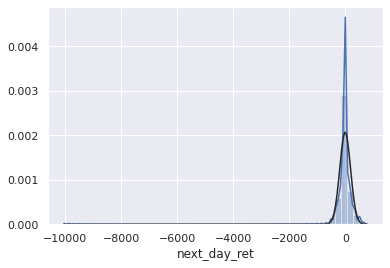

In [ ]:
sns.distplot(train.next_day_ret,fit=norm);
plt.title = ('next_day_ret');
print("skewness: %f" % train['next_day_ret'].skew())
print("kurtosis: %f" % train ['next_day_ret'].kurt())

high kurtosis and low skewness are not good for our model we need to reduce them as possible as we can . Possible reason is the existence of outliers 

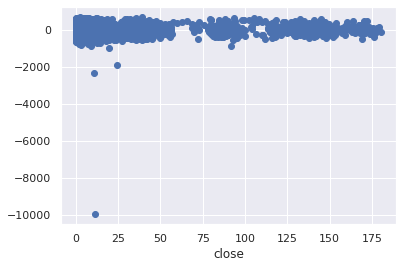

In [ ]:
#checking for outliers
plt.scatter(train.close,train.next_day_ret, marker='o');
plt.xlabel("close")
plt.show()


from this two graphs we decide to remove any value of next return which is smaller than -1000 as they seems to be outliers 

skewness: 0.300349
kurtosis: 1.956704


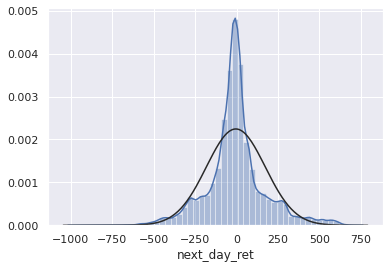

In [ ]:
#Deleting outliers
train=train[abs(train['next_day_ret'])<1000]
#Check the graphic again
sns.distplot(train.next_day_ret,fit=norm);
plt.title = ('next_day_ret');
print("skewness: %f" % train['next_day_ret'].skew())
print("kurtosis: %f" % train ['next_day_ret'].kurt())

The distribution of the the target improved very well even though it's not normal

###### let's check for outliers in other features

In [ ]:
numerical = ['yesterday_price', 'open', 'last', 'close', 'low','high', 'qty_traded', 'num_trades', 'value']

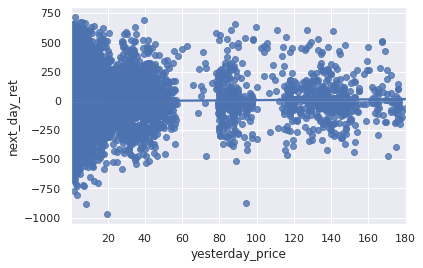

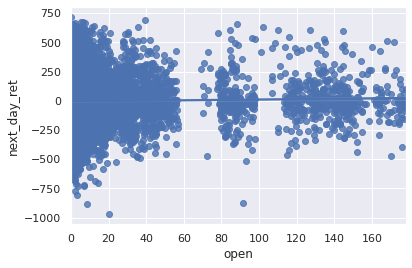

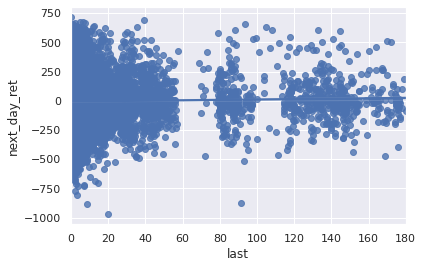

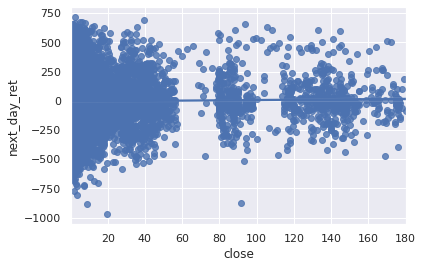

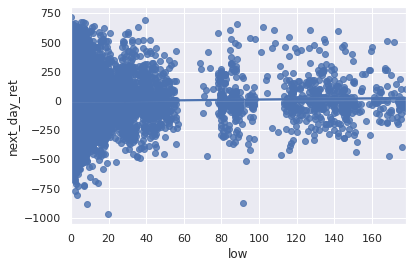

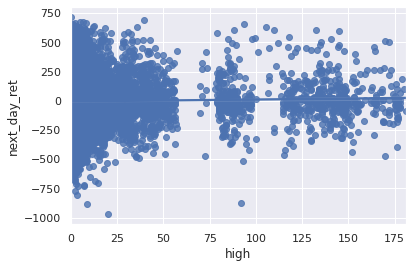

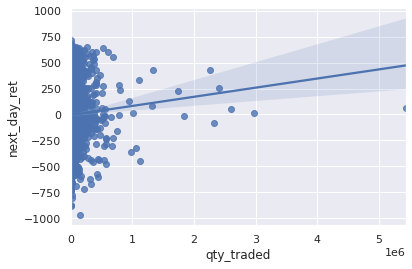

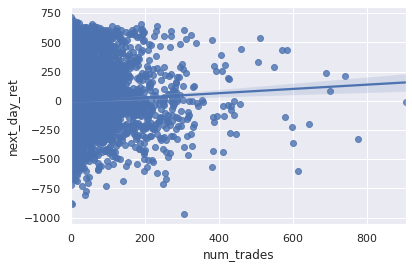

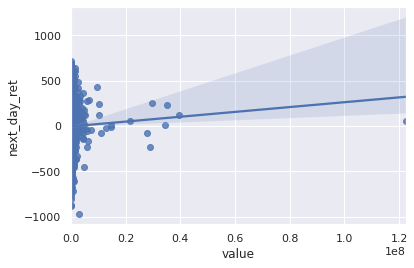

In [ ]:
for var in numerical:
    ax =sns.regplot(x=var, y="next_day_ret", data=train)

    plt.plot()
    plt.show()

As we see here , **qty_traded** and **value** have outliers . let's drop them

In [ ]:
train = train.drop(train[(train['qty_traded']>4000000)].index)

In [ ]:
train = train.drop(train[(train['value']>100000000)].index)

## Correlation matrix

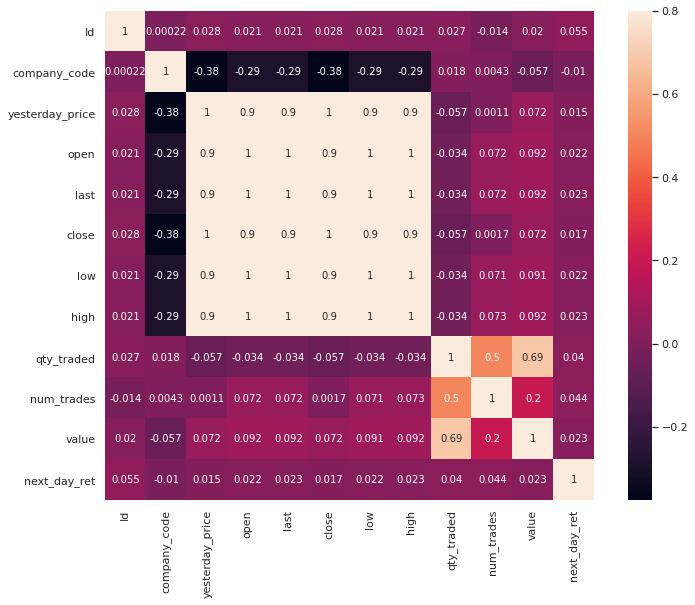

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);


the linear relationships between the features and next_day_ret is very weak . However , we will try the linear model

In [ ]:
#set index as date 
train.index=train['date']
test.index=test['date']
#store the date
train_date=train["date"]
test_date=test["date"]
#drop the date
train.drop("date",axis=1,inplace=True)
test.drop("date",axis=1,inplace=True)
train.head()

,Id,company_code,company,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,next_day_ret
date,,,,,,,,,,,,,
2018-01-02,0,725001,ADWYA,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50,-161.101159
2018-01-02,1,340005,AMEN BANK,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00,-91.056323
2018-01-02,2,730001,ARTES,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05,159.011983
2018-01-02,3,714001,ASSAD,9.00,0.00,0.00,9.00,0.00,0.00,0,0,0.00,-98.000768
2018-01-02,4,360035,ATB,4.22,4.15,4.18,4.18,4.15,4.18,3705,7,15465.90,-158.659992


In [ ]:
#store id for submissions
train_ID=train["Id"]
test_ID=test["Id"]

In [ ]:
train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)

We will drop the company because it gives the same information as company_code

In [ ]:
#store the feature
train_Company=train["company"]
test_Company=test["company"]

In [ ]:
train.drop("company",axis=1,inplace=True)
test.drop("company",axis=1,inplace=True)

In [ ]:
#Seperate the target and the train set
target=train["next_day_ret"]
train.drop("next_day_ret",axis=1,inplace=True)
target.shape

(20413,)

In [ ]:
All_data=pd.concat([train,test])

Let's add the current return as it will improve our model

In [ ]:
All_data['currReturn']=All_data.groupby(['company_code'])['close'].pct_change()


In [ ]:
#now that we grouped by company_code we will drop it 
All_data.drop("company_code", axis = 1, inplace = True)


the first value of currReturn of every company is NaN that's why will replace it with 0

In [ ]:
All_data["currReturn"]=All_data["currReturn"].fillna(0)

#### Checking for skewed features 

In [ ]:
numeric = All_data.dtypes[All_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = All_data[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
value,67.516557
qty_traded,59.684381
num_trades,5.611837
high,4.676372
last,4.667051
open,4.664597
low,4.652407
yesterday_price,4.049714
close,4.048641
currReturn,0.091226


Apart from currReturn , the other features are highly skewed that's why will log1p transform them as it was the best transformation after many tries

In [ ]:
skewness.drop('currReturn',inplace=True)

In [ ]:
print("There are {} skewed numerical features to transform".format(skewness.shape[0]))

skewed_features = skewness.index
for feat in skewed_features:
    All_data[feat] = np.log1p(All_data[feat])


There are 9 skewed numerical features to transform


# Modeling with factor analysis

Factor Analysis as a statistical method that will help us  represent a set of given variables by a smaller number.

Given the correlation matrix above , I had the intuition that I had to represent the highly correlated variable like (close,last,etc) by a smaller number of variables that we will choose later

In [ ]:
data=All_data.loc[:,['open','last','close','low','high','yesterday_price']]

In [ ]:
!pip install factor-analyzer

     |████████████████████████████████| 40 kB 1.8 MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-py3-none-any.whl size=40380 sha256=46c38da4fa56c099fade5b9a6c1fa6d21fb63a28606960be56d547f1332c6de8
  Stored in directory: /root/.cache/pip/wheels/8d/9e/4c/fd4cb92cecf157b13702cc0907e5c56ddc48e5388134dc9f1a
Successfully built factor-analyzer


In [ ]:
from factor_analyzer import FactorAnalyzer

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(data)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

In [ ]:
eigen_values, vectors = fa.get_eigenvalues()
eigen_values

array([5.00810393e+00, 9.91739341e-01, 9.38255396e-05, 3.56600299e-05,
       2.07066289e-05, 6.53903914e-06])

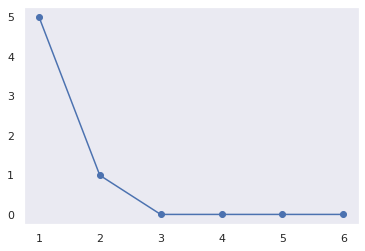

In [ ]:
plt.scatter(range(1,data.shape[1]+1),eigen_values)
plt.plot(range(1,data.shape[1]+1),eigen_values)
plt.grid()
plt.show()

We have 2 eignvalues above 1 so we will consider 2 factors and add a new feature to our dataset

In [ ]:
features=['open','last','close','low','high','yesterday_price']
i=0
All_data_fa=All_data.copy()
All_data_fa['nex_factor']=0
for f in features: 
    All_data_fa['nex_factor']=All_data_fa['nex_factor'] + fa.loadings_[:,0][i]*All_data_fa[f]+fa.loadings_[:,1][i]*All_data_fa[feat]

In [ ]:
All_data_fa.head()

,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value,currReturn,nex_factor
date,,,,,,,,,,,
2018-01-02,1.848455,1.832581,1.854734,1.854734,1.832581,1.854734,7.981733,2.079442,9.657363,0.0,7.952677
2018-01-02,3.232779,3.233961,3.218876,3.218876,3.218876,3.233961,7.326466,2.564949,10.516482,0.0,13.929433
2018-01-02,1.974081,1.983756,1.960095,1.960095,1.958685,1.983756,10.487824,4.219508,12.296923,0.0,8.514156
2018-01-02,2.302585,0.000000,0.000000,2.302585,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.019196
2018-01-02,1.652497,1.638997,1.644805,1.644805,1.638997,1.644805,8.217708,2.079442,9.646458,0.0,7.092169


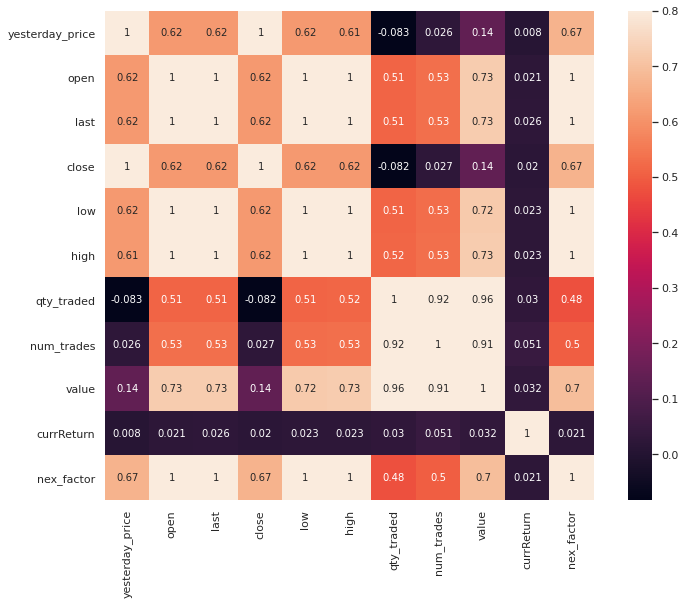

In [ ]:
#correlation matrix
corrmat = All_data_fa.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);


Now that we created a new feature from correlation we will drop open , last , low and high because the have 1 correlation with the new feature

In [ ]:
All_data_fa.drop("open",axis=1,inplace=True)
All_data_fa.drop("last",axis=1,inplace=True)
All_data_fa.drop("high",axis=1,inplace=True)
All_data_fa.drop("low",axis=1,inplace=True)

In [ ]:
#we will drop yesterday_price because of the correlation with close
All_data_fa.drop("yesterday_price",axis=1,inplace=True)

###### let's resplit the data for model evaluation 

In [ ]:
train = pd.DataFrame(All_data_fa[:train.shape[0]])
test = pd.DataFrame(All_data_fa[train.shape[0]:])

In [ ]:
train.head()

,close,qty_traded,num_trades,value,currReturn,nex_factor
date,,,,,,
2018-01-02,1.854734,7.981733,2.079442,9.657363,0.0,7.952677
2018-01-02,3.218876,7.326466,2.564949,10.516482,0.0,13.929433
2018-01-02,1.960095,10.487824,4.219508,12.296923,0.0,8.514156
2018-01-02,2.302585,0.000000,0.000000,0.000000,0.0,1.019196
2018-01-02,1.644805,8.217708,2.079442,9.646458,0.0,7.092169


In [ ]:
test.head()

,close,qty_traded,num_trades,value,currReturn,nex_factor
date,,,,,,
2019-01-02,1.757858,8.365672,1.791759,9.934104,0.021277,7.566863
2019-01-02,3.358638,5.568345,2.302585,8.887523,-0.001799,14.486323
2019-01-02,1.985131,7.837160,1.609438,9.675651,0.001595,8.561528
2019-01-02,2.199444,9.607706,4.143135,11.683456,0.028205,9.413773
2019-01-02,1.536867,6.280396,2.639057,7.575441,-0.002732,6.699756


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16330, 6), (4083, 6), (16330,), (4083,))

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn import linear_model 
lr = linear_model.LinearRegression() 
lr.fit(X_train,y_train) 
preds = lr.predict(X_test) 
val_mae2 =np.sqrt(mean_squared_error( y_test, preds ))
print(val_mae2)

169.51044478331255


We got a high rmse score like we expected

In [ ]:
preds_FA=lr.predict(test) 

In [ ]:
SUB_FA=pd.DataFrame()
SUB_FA["Id"]=test_ID
SUB_FA["next_day_ret"]=preds_FA

In [ ]:
SUB_FA.shape

(20331, 2)

In [ ]:
SUB_FA.to_csv("finalFA.csv",index=False)

# Modeling with PCA

The role of PCA is the to reduce dimension (we have already few features ) and make correlated variables independant . That's why we are going to apply it to the correlated ones 

In [ ]:
data_pca=All_data.loc[:,['open','last','close','low','high','yesterday_price']]

In [ ]:
data_pca.head()

,open,last,close,low,high,yesterday_price
date,,,,,,
2018-01-02,1.832581,1.854734,1.854734,1.832581,1.854734,1.848455
2018-01-02,3.233961,3.218876,3.218876,3.218876,3.233961,3.232779
2018-01-02,1.983756,1.960095,1.960095,1.958685,1.983756,1.974081
2018-01-02,0.000000,0.000000,2.302585,0.000000,0.000000,2.302585
2018-01-02,1.638997,1.644805,1.644805,1.638997,1.644805,1.652497


We will try to scale our data for the PCA 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)
data_scaled[:5]

array([[ 0.20568172,  0.22237344, -0.20763421,  0.21015412,  0.21893887,
        -0.21348282],
       [ 1.29821534,  1.28565492,  1.06267235,  1.29279218,  1.29246897,
         1.07586672],
       [ 0.32353953,  0.3044968 , -0.10952111,  0.30863599,  0.31936397,
        -0.09647545],
       [-1.22302204, -1.22330102,  0.20941037, -1.22101555, -1.22470513,
         0.20949092],
       [ 0.05476059,  0.05874391, -0.40312305,  0.05897251,  0.05553916,
        -0.39599617]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
# Fit
pca.fit(data_scaled)
# Generatefeatures
data_pca = pca.transform(data_scaled)

In [ ]:
data_pca

array([[ 2.21712089e-01, -4.72439328e-01, -9.69448230e-03,
         5.17202554e-03, -8.05212836e-03,  1.97670944e-04],
       [ 2.99440521e+00,  1.37790068e-02,  1.24015996e-02,
         1.47553903e-03,  3.46203341e-03,  8.08196963e-04],
       [ 4.70529136e-01, -4.40717879e-01,  1.35685936e-02,
         7.88494909e-03,  8.35990291e-03,  1.39524299e-03],
       ...,
       [-1.38124755e+00, -7.63095184e-01,  4.93577477e-03,
        -5.14918394e-03, -2.33337340e-03, -3.30717403e-04],
       [-7.91542551e-01, -6.64113715e-01, -1.61796007e-02,
         3.70529769e-04, -8.83553524e-04,  1.09691441e-03],
       [-2.99829853e+00, -2.97021725e-01,  3.66829231e-04,
        -3.60227481e-03, -6.46513674e-05,  1.08789281e-04]])

In [ ]:
# explained variance
explained_variance=pca.explained_variance_ratio_
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [ ]:
# variance captured with the first two components
cumulative_explained_variance[1]

0.9999738781270874

In [ ]:
#we are going to keep 6 components
pca = PCA(n_components=6)
data_pca = pca.fit_transform(data_scaled)
data_pca.shape

(40744, 6)

###### add the new features (PC)


In [ ]:
pca_feats = pd.DataFrame(data_pca)
pca_feats.columns = ['PC{}'.format(i + 1) for i in range(data_pca.shape[1])]
# Update its index
pca_feats.index = All_data.index
pca_feats.head()

,PC1,PC2,PC3,PC4,PC5,PC6
date,,,,,,
2018-01-02,0.221712,-0.472439,-0.009694,0.005172,-0.008052,0.000198
2018-01-02,2.994405,0.013779,0.012402,0.001476,0.003462,0.000808
2018-01-02,0.470529,-0.440718,0.013569,0.007885,0.008360,0.001395
2018-01-02,-1.968471,1.481854,-0.000110,-0.000737,0.000098,0.000044
2018-01-02,-0.184440,-0.546141,0.003623,-0.002336,-0.005112,-0.000455


In [ ]:
All_data_pca=All_data.copy()

In [ ]:
All_data_pca["PC1"]=pca_feats["PC1"]
All_data_pca["PC2"]=pca_feats["PC2"]
All_data_pca["PC3"]=pca_feats["PC3"]
All_data_pca["PC4"]=pca_feats["PC4"]
All_data_pca["PC5"]=pca_feats["PC5"]
All_data_pca["PC6"]=pca_feats["PC6"]


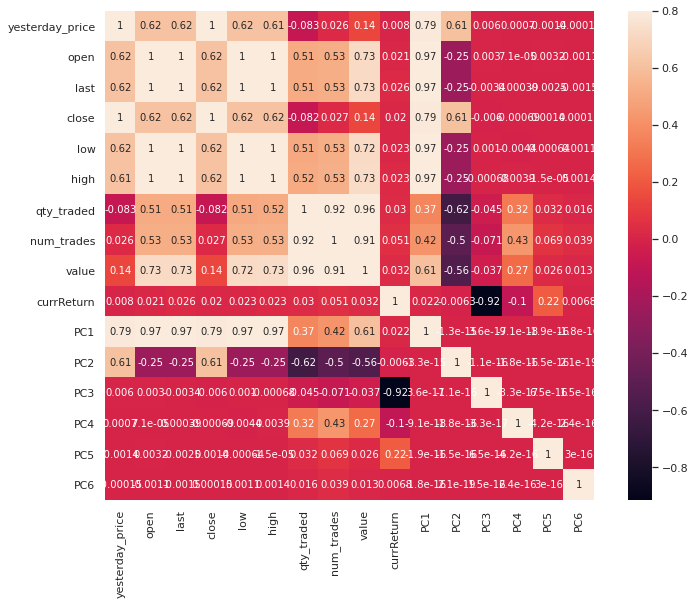

In [ ]:
#correlation matrix
corrmat = All_data_pca.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);


Like we did before we will drop the correlated features

In [ ]:
All_data_pca.drop("open",axis=1,inplace=True)
All_data_pca.drop("last",axis=1,inplace=True)
All_data_pca.drop("high",axis=1,inplace=True)
All_data_pca.drop("low",axis=1,inplace=True)

In [ ]:
All_data_pca.drop("yesterday_price",axis=1,inplace=True)

In [ ]:
#resplitting
train_pca = pd.DataFrame(All_data_pca[:train.shape[0]])
test_pca = pd.DataFrame(All_data_pca[train.shape[0]:])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pca, target, test_size = 0.2, random_state = 1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16330, 11), (4083, 11), (16330,), (4083,))

In [ ]:
lr = linear_model.LinearRegression() 
lr.fit(X_train,y_train) 
preds = lr.predict(X_test) 
val_mae2 =np.sqrt(mean_squared_error( y_test, preds ))
print(val_mae2)

168.39847045489861


In [ ]:
preds_pca=lr.predict(test_pca)

In [ ]:
SUB_pca=pd.DataFrame()
SUB_pca["Id"]=test_ID
SUB_pca["next_day_ret"]=preds_pca

In [ ]:
SUB_pca.to_csv("finalPCA.csv",index=False)

The score is still high but we got a slightly better results than the FA because we did make the principal componenets independents

# Time splitting

In the previous models we were using a random train_test_split which may use future information beyond day N in the test data to predict day N returns. Now we will split the data by time 

We will continue with the PCA model

In [ ]:
train_pca.head()

,close,qty_traded,num_trades,value,currReturn,PC1,PC2,PC3,PC4,PC5,PC6
date,,,,,,,,,,,
2018-01-02,1.854734,7.981733,2.079442,9.657363,0.0,0.221712,-0.472439,-0.009694,0.005172,-0.008052,0.000198
2018-01-02,3.218876,7.326466,2.564949,10.516482,0.0,2.994405,0.013779,0.012402,0.001476,0.003462,0.000808
2018-01-02,1.960095,10.487824,4.219508,12.296923,0.0,0.470529,-0.440718,0.013569,0.007885,0.008360,0.001395
2018-01-02,2.302585,0.000000,0.000000,0.000000,0.0,-1.968471,1.481854,-0.000110,-0.000737,0.000098,0.000044
2018-01-02,1.644805,8.217708,2.079442,9.646458,0.0,-0.184440,-0.546141,0.003623,-0.002336,-0.005112,-0.000455


In [ ]:
train_date.values

array(['2018-01-02', '2018-01-02', '2018-01-02', ..., '2018-12-31',
       '2018-12-31', '2018-12-31'], dtype=object)

In [ ]:
#add company and date back 
train_pca["company"]=train_Company
test_pca["company"]=test_Company
train_pca["date"]=train_date.values
test_pca["date"]=test_date.values
X_all_time=pd.concat([train_pca,test_pca])

In [ ]:
#convert object to datetime
X_all_time['date'] = pd.to_datetime(X_all_time['date'])
X_all_time.dtypes

close                float64
qty_traded           float64
num_trades           float64
value                float64
currReturn           float64
PC1                  float64
PC2                  float64
PC3                  float64
PC4                  float64
PC5                  float64
PC6                  float64
company               object
date          datetime64[ns]
dtype: object

In [ ]:
#get dummies from company so the model can identify every company alone 
nominal_dumm=pd.get_dummies(X_all_time['company'])
nominal_dumm.head()

,ADWYA,AETECH,AIR LIQUDE TSIE,ALKIMIA,AMEN BANK,AMS,ARTES,ASS MULTI ITTIHAD,ASSAD,ASTREE,...,TELNET HOLDING,TPR,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#add the one-hot-encoding to data 
data=pd.concat([X_all_time ,nominal_dumm], axis=1)
data=data.drop('company',axis=1)
data.index = data['date']
data.drop('date', axis=1, inplace=True)
data

,close,qty_traded,num_trades,value,currReturn,PC1,PC2,PC3,PC4,PC5,...,TELNET HOLDING,TPR,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1.854734,7.981733,2.079442,9.657363,0.000000,0.221712,-0.472439,-0.009694,0.005172,-0.008052,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,3.218876,7.326466,2.564949,10.516482,0.000000,2.994405,0.013779,0.012402,0.001476,0.003462,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,1.960095,10.487824,4.219508,12.296923,0.000000,0.470529,-0.440718,0.013569,0.007885,0.008360,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,2.302585,0.000000,0.000000,0.000000,0.000000,-1.968471,1.481854,-0.000110,-0.000737,0.000098,...,0,0,0,0,0,0,0,0,0,0
2018-01-02,1.644805,8.217708,2.079442,9.646458,0.000000,-0.184440,-0.546141,0.003623,-0.002336,-0.005112,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30,0.285179,6.685861,1.098612,5.579730,0.000000,-2.914886,-1.040425,0.000679,-0.005222,-0.000178,...,0,0,0,0,0,0,0,0,0,0
2019-12-30,0.198851,0.000000,0.000000,0.000000,0.000000,-3.356666,-0.916049,0.000533,-0.004599,-0.000121,...,0,0,0,0,0,0,0,0,0,0
2019-12-30,1.047319,4.836282,0.693147,5.447814,-0.010695,-1.381248,-0.763095,0.004936,-0.005149,-0.002333,...,0,0,0,0,0,0,0,0,0,0


### Splitting

In [ ]:
valid_size = 0.2
valid_split_idx = int(train.shape[0] * (1-valid_size))
train_df  = data.iloc[:valid_split_idx].copy()
valid_df  = data.iloc[valid_split_idx:train.shape[0]].copy()
test_df   = data.iloc[train.shape[0]:].copy()

### plotting

Text(0, 0.5, 'TND')

<Figure size 1080x360 with 0 Axes>

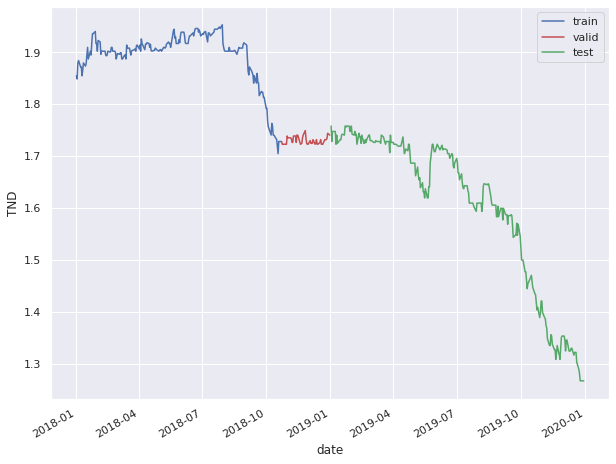

In [ ]:
plt.figure(figsize=(15, 5));

from pylab import rcParams

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_df[train_df.ADWYA==1].plot(y='close', style='b-', grid=True)
ax = valid_df[valid_df.ADWYA==1].plot(y='close', style='r-', grid=True,ax=ax)
ax = test_df[test_df.ADWYA==1].plot(y='close', style='g-', grid=True, ax=ax)
ax.legend(['train','valid','test'])
ax.set_xlabel("date")
ax.set_ylabel("TND")

### modeling

In [ ]:
y_train=target.iloc[:valid_split_idx].copy()
y_valid=target.iloc[valid_split_idx:train.shape[0]].copy()

In [ ]:
lr_time = linear_model.LinearRegression() 
lr.fit(train_df,y_train) 
preds = lr.predict(valid_df) 
val_mae2 =np.sqrt(mean_squared_error( y_valid, preds ))
print(val_mae2)

187.90551803967668


Even though the score is higher , this is the right approach 

# Residual analysis

Residuals  are the differences between the true value and the predicted value.  
If the model is good the mean of the the residuals would be 0 

We will try residual analysis on our last model. Other models residual won't differ that much given the poor performance

In [ ]:
residuals = y_valid.values-preds
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 18.10702393528947


As we see here that's not the case . Let's try to plot the residuals

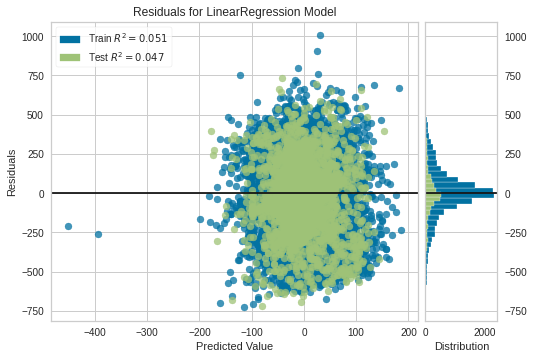

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lr)
visualizer.fit(train_df, y_train)  # Fit the training data to the visualizer
visualizer.score(valid_df, y_valid)  # Evaluate the model on the test data
visualizer.show()

By simply observing the distribution of residuals, our qualitative conclusion is that the data is heteroscedastic and doesn't satisfy the assumptions for linear regression.

###  Heteroscedasticity Test

In [ ]:
import statsmodels.stats.diagnostic as smd
bp_test = smd.het_breuschpagan(residuals, valid_df)
print("Lagrange Multiplier Statistic:", bp_test[0])
print("P-value:", bp_test[1])
print("f-value:", bp_test[2])
print("f_p-value:", bp_test[3], "\n")
if bp_test[1] > 0.05:
    print ("The relationship is not heteroscedastic.")
if bp_test[1] < 0.05:
    print ("The relationship is heteroscedastic.")

Lagrange Multiplier Statistic: 946.1052108134172
P-value: 7.803382552083967e-142
f-value: 13.227562343361484
f_p-value: 1.416772864212717e-165 

The relationship is heteroscedastic.


Because the P-value is less than 0.05, we have enough evidence to reject the null hypothesis that the relationship is homoscedastic. This result matches up with our qualitative conclusion.